In [1]:
# ベイズ法によるパラメータ推測
# データが観測されると、データの情報と事前情報(事前分布)を
# バランスさせた形で事後分布へと更新する手続きのことをベイズ法という

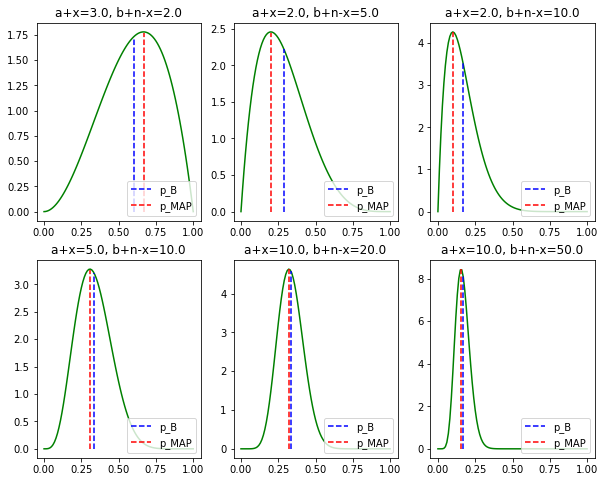

In [19]:
# ベイズ法による点推定
# 

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

a, b = np.array([3., 2., 2., 5., 10., 10.]), np.array([2., 5., 10., 10., 20., 50.])
x = np.arange(0., 1.01, 0.01)
y = np.zeros([x.shape[0], a.shape[0]])

plt.figure(figsize=(10,8))
for i in range(6):
    y[:,i] = stats.beta.pdf(x, a[i], b[i])
    plt.subplot(2,3,i+1)
    plt.plot(x,y[:,i],color="green")
    plt.plot(np.repeat(a[i]/(a[i]+b[i]),20),np.linspace(0,stats.beta.pdf(a[i]/(a[i]+b[i]), a[i], b[i])-0.01,20),"b--", label="p_B")
    plt.plot(np.repeat((a[i]-1.)/(a[i]+b[i]-2.),20),np.linspace(0, stats.beta.pdf((a[i]-1.)/(a[i]+b[i]-2.), a[i], b[i])-0.01, 20),"r--", label="p_MAP")
    plt.title("a+x={}, b+n-x={}".format(a[i],b[i]))
    plt.legend(loc=4)

plt.show()

# 観測サンプルが多くなるにつれて推定結果がに収束していくことが確認できる。
# また、ベイズ推定量とMAP推定量はそれぞれの推定値がより大きいか小さいかによってどちらの推定値が大きいかが定まることも読み取れる。

In [20]:
# ベイズ法による区間推定
# 信頼区間ではなく、「信用区間」が通常用いられる
# 真のパラメータがその区間に存在する確率そのものを意味する

mean: 4.548155045233808
standard deviation: 0.42388274575892587


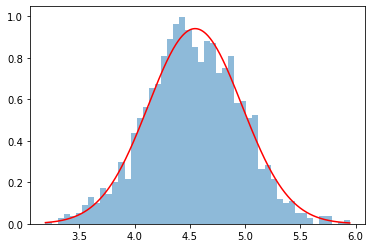

In [26]:
# MHアルゴリズムとは
# 求める確率分布を均衡分布として持つマルコフ連鎖を作成することによって、
# 確率分布のサンプリングを行う種々のアルゴリズムは「MCMC法」と呼ばれる
# MCMC法の中で、最も基本的な方法が「MHアルゴリズム」である

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm

# 適当なデータを生成
mu_X = 5.0
sigma_X = 3.0
N = 50
X = norm.rvs(mu_X, sigma_X, size=N)

# 事前分布を設定(平均：μ0=1.0、標準偏差：σ0=10のガウス分布)
mu_0 = 1.0
sigma_0 = 10

# 提案分布関数のパラメータ
sigma_q = 0.5

# 事前分布を返す関数
def prior(mu):
    return norm.pdf(mu, mu_0, sigma_0)

# 提案分布関数：目標分布からのサンプリングを行う
def q(mu, mu_cond):
    return norm.pdf(mu, mu_cond, sigma_q)

# 提案分布から候補点をランダムに取得する関数
def sampling_q(mu):
    return norm.rvs(mu, sigma_q)

# 周辺尤度を計算する関数
def f(mu, X):
    # 尤度x事前分布
    return np.prod(norm.pdf(X, mu, sigma_X)) * prior(mu)

# MH法によるサンプリング関数
def MH_method(w, X, q, sampling_q, f):    
    # 1. 提案分布から候補点を取得
    w_new = sampling_q(w)
    # 2. 候補点の採択確率計算
    a = (f(w_new, X)*q(w, w_new))/(f(w, X)*q(w_new, w))
    # 3. 採択判定
    is_accept = np.random.uniform() < min(1, a)
    return w_new, is_accept

# MH法でサンプルリストを取得する関数
def sampling_MH(X, q, sampling_q, f, sample_num, warmup, w_init):    
    w = w_init
    samples = []
    while(len(samples) < sample_num + warmup):
        w_new, is_accept = MH_method(w, X, q, sampling_q, f)
        # 4. 採択された場合はwを遷移
        if is_accept:
            w = w_new
            samples.append(w)
    samples = samples[warmup:]
    return samples


sample_num = 2000
warmup = 500 # 初期値の影響を受けるので、いくつかのサンプルは無視する
mu_init = 0.0
mu_samples = sampling_MH(X, q, sampling_q, f, sample_num, warmup, mu_init)


# muの事後分布
X_mean = np.average(X)
eq_mu_N = (sigma_X**2*mu_0 + N*sigma_0**2*X_mean)/(sigma_X**2 + N*sigma_0**2)
eq_sigma_N = np.sqrt((sigma_0**2*sigma_X**2)/(sigma_X**2 + N*sigma_0**2))
print('mean:', eq_mu_N)
print('standard deviation:', eq_sigma_N)

# muの事後分布を描画
plt.hist(mu_samples, bins=50, density=True, alpha=0.5)
plt_arr = np.linspace(min(mu_samples), max(mu_samples), 1000)
plt.plot(plt_arr, norm.pdf(plt_arr, eq_mu_N, eq_sigma_N), c='r')
plt.show()

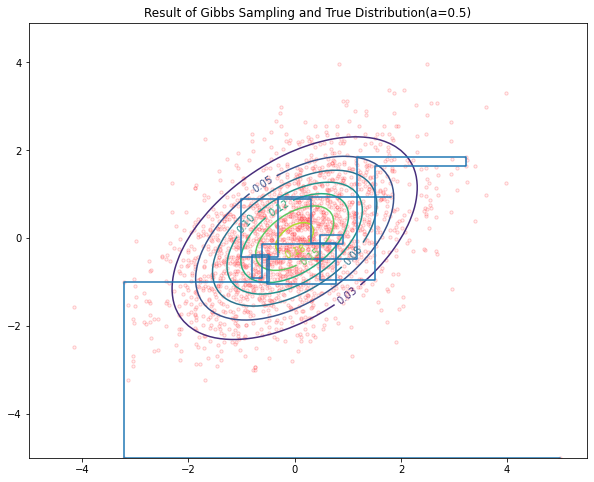

In [29]:
# ギブス・サンプリングとは
# 事後分布からのサンプリングとして、MHアルゴリズムと並んでよく用いられる

import numpy as np
import matplotlib.pyplot as plt
import math

# 多変量ガウス分布データを計算
def gaussian(x, y, mean, co_var):
    output = np.array([])
    x = x - mean[0]
    y = y - mean[1]
    for i in range(x.shape[0]):
        z = 1/(2*math.pi)*math.sqrt(np.linalg.det(co_var))*np.exp(-0.5 * np.dot(np.dot(np.array([x[i, :],y[i, :]]).T, np.linalg.inv(co_var)), np.array([x[i, :],y[i, :]])))
        z = np.diag(z)
        output = np.append(output, z)
    output = output.reshape(x.shape[0], x.shape[0])
    return output

# 初期データ
x = np.array([5., -5.])

# 完全条件付き分布のパラメータ
a = 0.5

step = 1000
sample = np.array(x)

# ギブス・サンプリングを実行
for i in range (step):
    x[0] = np.random.normal(a*x[1], 1) # 与えられたx1でp(x0∣x1)に基づいてx0を発生させる
    sample = np.append(sample, (x))
    x[1] = np.random.normal(a*x[0], 1) # 与えられたx0でp(x1∣x0)に基づいてx1を発生させる
    sample = np.append(sample, (x))

sample = sample.reshape((2*step+1, x.shape[0]))

# 多変量ガウス分布を描画
t = np.arange(-5, 5, 0.1)
x,y =np.meshgrid(t, t)
z = gaussian(x, y, np.array([0, 0]), 1/(1-a**2) * np.array([[1, a],[a, 1]]))

plt.figure(figsize=(10,8))
plt.title('Result of Gibbs Sampling and True Distribution(a={})'.format(a))
plt.scatter(sample[:, 0], sample[:, 1], s=10, c='pink', alpha=0.2, edgecolor='red')

# ギブス・サンプルのトラッキングを描画
plt.plot(sample[0:30, 0], sample[0:30, 1])

c = plt.contour(x,y,z)
c.clabel(fmt='%1.2f', fontsize=10)
plt.show()